<a href="https://colab.research.google.com/github/shashankchintu99/semester3-projects/blob/main/deeplearning/assignments/Shashankreddy_HW5_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part 1: GAN

## Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.

In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

fashionmnist = FashionMNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|██████████| 26421880/26421880 [00:01<00:00, 17524729.84it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 296253.56it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5441316.11it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8724152.32it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



##  we are transforming the pixel values, originally within the range [0, 1], to a new range of [-1, 1]

In [ ]:
# Access the first image and label
img, label = fashionmnist[0]
# Print the label and a small portion of the image
print('Label: ', label)

# Print the minimum and maximum values of the image
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

As expected, the pixel values range from -1 to 1. Let's define a helper to denormalize and view the images. This function will also be useful for viewing the generated images

In [ ]:
# denormalizing the images in range between 0 and 1
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


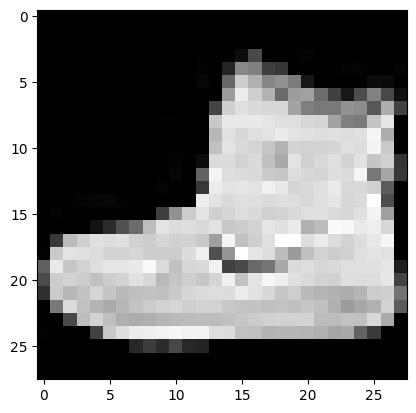

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

# creating a dataloader to load the images in batches.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(fashionmnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([5, 5, 4, 7, 7, 5, 5, 0, 5, 2, 3, 6, 7, 8, 5, 6, 7, 4, 2, 5, 6, 0, 5, 4,
        4, 0, 3, 0, 6, 7, 6, 8, 4, 5, 8, 4, 5, 0, 8, 0, 6, 4, 7, 8, 3, 1, 1, 2,
        1, 0, 2, 7, 0, 6, 3, 7, 4, 3, 3, 4, 0, 8, 8, 0, 4, 3, 2, 7, 0, 6, 6, 7,
        9, 0, 0, 7, 5, 5, 4, 2, 1, 0, 6, 7, 5, 9, 3, 5, 7, 4, 1, 6, 0, 3, 7, 8,
        2, 6, 2, 3])


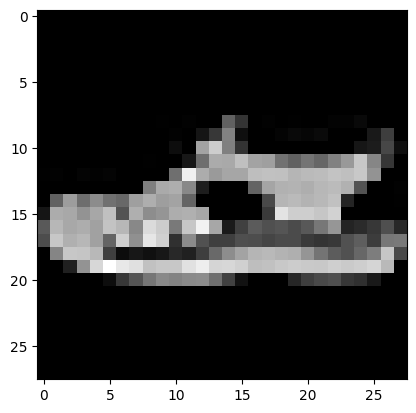

In [ ]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

## We'll also create a `device` which can be used to move the data and models to a GPU, if one is available.

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

## Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. While we can use a CNN for the discriminator, we'll use a simple feedforward network with 3 linear layers to keep things since. We'll treat each 28x28 image as a vector of size 784.

In [ ]:
image_size = 784
hidden_size = 256

In [ ]:
# Define a discriminator network 'D' for binary classification with three linear layers and LeakyReLU activations,
# ending with a sigmoid for output normalization.
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

We use the Leaky ReLU activation for the discriminator.

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*6DZve_x3t08PcwYm.JPG" width="420">


>  Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient.

Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being fake i.e. generated.



In [ ]:
#Let's move the discriminator model to the chosen device.#
D.to(device);

## Generator Network

The input to the generator is typically a vector or a matrix which is used as a seed for generating an image. Once again, to keep things simple, we'll use a feedfoward neural network with 3 layers, and the output will be a vector of size 784, which can be transformed to a 28x28 px image.

In [ ]:
latent_size = 64

In [ ]:
# Constructing a generator network 'G' with three linear layers and ReLU activations, outputting through a Tanh layer to match image data dimensions and scale.

G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

We use the TanH activation function for the output layer of the generator.

<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >



In [ ]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

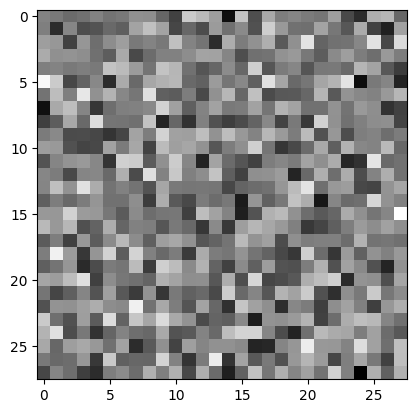

In [ ]:
plt.imshow(gen_imgs[0], cmap='gray');

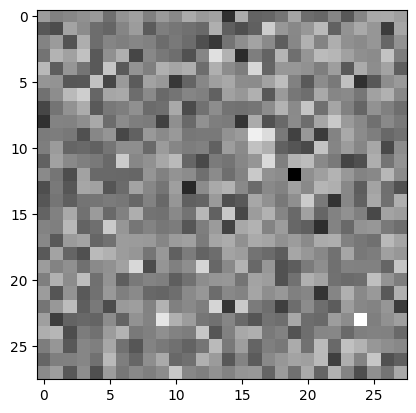

In [ ]:
plt.imshow(gen_imgs[1], cmap='gray');

As one might expect, the output from the generator is basically random noise. Let's define a helper function which can save a batch of outputs from the generator to a file.


In [ ]:
#Let's move the generator to the chosen device.
G.to(device);

## Discriminator Training

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

<img src="https://image.slidesharecdn.com/chrishokamp-dublinnlp3-160805110319/95/task-based-learning-for-nlp-going-beyond-cross-entropy-chris-hokamp-10-638.jpg?cb=1470395213" width="420" >

In [ ]:
# Initializing the binary cross-entropy loss function for the discriminator
# and set up its optimizer using Adam with a learning rate of 0.0002.

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [ ]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

During discriminator training, real images are processed to compute a loss with target labels set to 1, aiming for the discriminator to correctly classify them as genuine. Subsequently, fake images are generated by the generator, and the discriminator evaluates them, calculating a loss with target labels set to 0, pushing the discriminator to recognize them as generated. The combined losses from real and fake batches are then employed for gradient descent, updating the discriminator's weights via the d_optimizer. Importantly, the generator's weights remain untouched during this process, ensuring its parameters aren't altered during discriminator

#Generator Training

During generator training, batches of images are produced and fed into the discriminator. The loss is computed by setting target labels to 1 (indicating real images) to incentivize the generator to deceive the discriminator. The obtained loss is then used for gradient descent, adjusting the generator's weights to enhance its ability to generate more realistic images. This process iterates to refine the generator's performance over time.

In [ ]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [ ]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

# Training the Model

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model

#### Step 2. Train the GAN model to produce images in this new domain.

In [ ]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

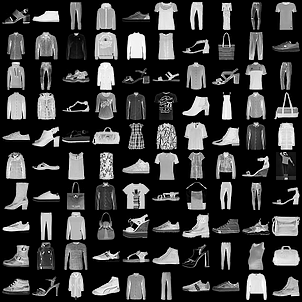

In [ ]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Additionally, we will create a utility function to save a batch of generated images to disk at the conclusion of each epoch. To observe the evolution of individual generated images throughout the training process, we'll employ a consistent set of input vectors for the generator.







Saving fake_images-0000.png


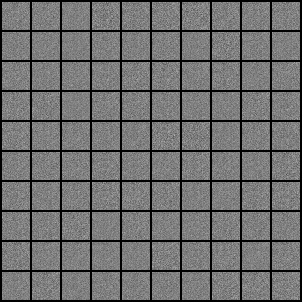

In [ ]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

We are now ready to train the model. In each epoch, we train the discriminator first, and then the generator. The training might take a while if you're not using a GPU.

In [32]:
%%time

num_epochs = 100
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/100], Step [200/600], d_loss: 0.0892, g_loss: 8.5449, D(x): 0.98, D(G(z)): 0.01
Epoch [0/100], Step [400/600], d_loss: 0.0224, g_loss: 6.4037, D(x): 0.99, D(G(z)): 0.02
Epoch [0/100], Step [600/600], d_loss: 0.3876, g_loss: 5.8010, D(x): 0.90, D(G(z)): 0.01
Saving fake_images-0001.png
Epoch [1/100], Step [200/600], d_loss: 0.0341, g_loss: 6.4355, D(x): 0.98, D(G(z)): 0.01
Epoch [1/100], Step [400/600], d_loss: 0.0427, g_loss: 5.0475, D(x): 0.99, D(G(z)): 0.03
Epoch [1/100], Step [600/600], d_loss: 0.0213, g_loss: 6.4001, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0002.png
Epoch [2/100], Step [200/600], d_loss: 0.1087, g_loss: 8.6006, D(x): 0.99, D(G(z)): 0.06
Epoch [2/100], Step [400/600], d_loss: 0.0396, g_loss: 6.7833, D(x): 0.99, D(G(z)): 0.02
Epoch [2/100], Step [600/600], d_loss: 0.1727, g_loss: 3.5582, D(x): 0.95, D(G(z)): 0.05
Saving fake_images-0003.png
Epoch [3/100], Step [200/600], d_loss: 0.1018, g_loss: 4.2876, D(x): 0.97, D(G(z)): 0.05
Epoch [3/100], Step [400/6


##Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.





difficulties : During initial epochs, images generated by the GAN might appear blurry or lack sharpness. This is a common issue as the model refines its ability to generate high-quality images over subsequent epochs.

In the early epochs, the generator may struggle to produce diverse images, leading to a phenomenon known as mode collapse, where it generates a limited set of outputs, lacking variety.

and finally GANs often exhibit a slow training process, requiring numerous epochs to reach convergence. This gradual pace can be attributed to the intricate dynamics between the generator and discriminator, making training more time-consuming compared to other neural network architectures.

Here's how the generated images look, after the 10th, 50th, 100th epochs of training.

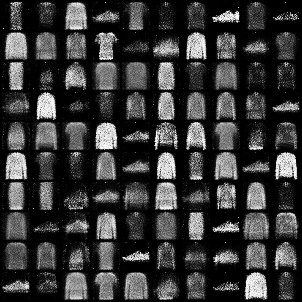

In [34]:
Image('./samples/fake_images-0020.png')

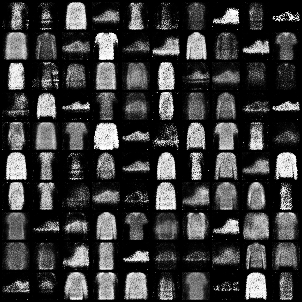

In [35]:
Image('./samples/fake_images-0040.png')

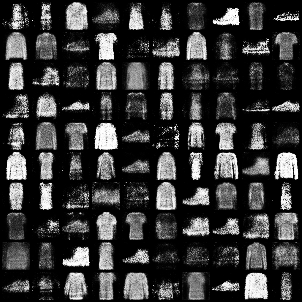

In [36]:
Image('./samples/fake_images-0060.png')

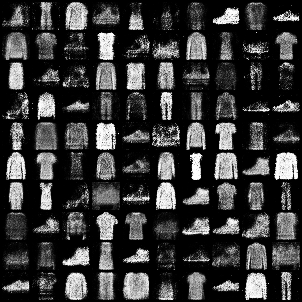

In [38]:
Image('./samples/fake_images-0080.png')

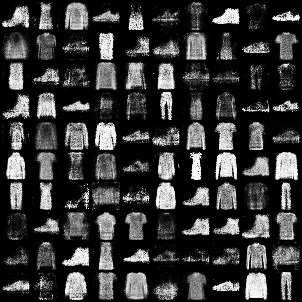

In [39]:
Image('./samples/fake_images-0100.png')

#### Step 4. Save the model weights in the folder to be used later.

In [33]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

In [47]:
folder_path = './fake_images_folder'

In [49]:
torch.save(G.state_dict(), os.path.join(folder_path,'generator_model.pth'))
torch.save(D.state_dict(), os.path.join(folder_path,'discriminator_model.pth'))

Displaying the iteration of epochs and improvement in the gnerator throught pictures

In [40]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/content/gans_training.avi

#### Losses of Discriminator and Generator

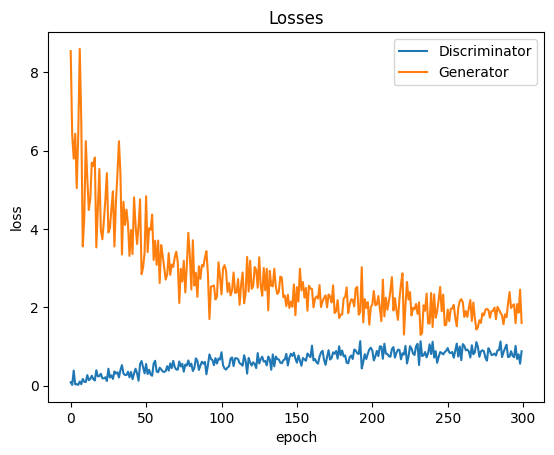

In [41]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

as from the above graph for generator the loss is decreasing as increase witht the number of epochs which shows the good sign that is its learning properly from the loss fucntion and the discriminator loss is increasing propotionally

#### Real Score Vs Fake Score

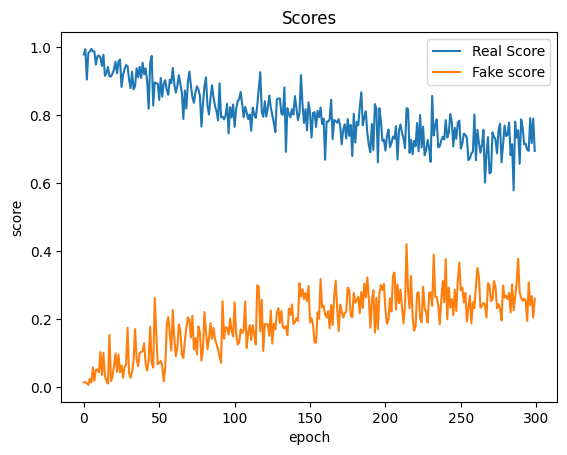

In [42]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

The graph emphasizes the real and fake scores, illustrating the discriminator's proficiency in distinguishing between authentic and generated images. The real score demonstrates a consistently high and stable performance, indicating reliable recognition of real images. In contrast, the fake score initiates at a low point and shows an ascending trajectory, signifying the generator's incremental success in producing images that increasingly resemble real ones. This trend reflects the generator's improving ability to deceive the discriminator throughout the training process.

In [50]:
# Load the generator model
G.load_state_dict(torch.load(os.path.join(folder_path, 'generator_model.pth')))
G.eval()  # Set the model to evaluation mode

# Load the discriminator model
D.load_state_dict(torch.load(os.path.join(folder_path, 'discriminator_model.pth')))
D.eval()  # Set the model to evaluation mode

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

#### Step 6: Re-train the GAN model to see if you can improve.

In [53]:
import torch.optim as optim

# Define the RMSprop optimizers for both networks
d_optimizer = optim.RMSprop(D.parameters(), lr=0.0001)
g_optimizer = optim.RMSprop(G.parameters(), lr=0.0001)

# Set the number of epochs to continue training and the starting epoch
num_additional_epochs = 50
start_epoch = 101
end_epoch = start_epoch + num_additional_epochs

# Calculate the total number of steps in each epoch
total_step = len(data_loader)

# Lists to keep track of losses and scores
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

# Training loop
for epoch in range(start_epoch, end_epoch):
    for i, (images, _) in enumerate(data_loader):
        # Reshape and load batch to device
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(images)
        # Train the generator
        g_loss, fake_images = train_generator()

        # Log the losses and scores every 200 steps
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(f'Epoch [{epoch}/{end_epoch - 1}], Step [{i + 1}/{total_step}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    # Save generated images for inspection (implement save_fake_images function as needed)
    save_fake_images(epoch)

# Function implementations for train_discriminator and train_generator are assumed to be provided


Epoch [101/150], Step [200/600], d_loss: 1.0405, g_loss: 1.1762, D(x): 0.64, D(G(z)): 0.35
Epoch [101/150], Step [400/600], d_loss: 1.0722, g_loss: 0.9906, D(x): 0.63, D(G(z)): 0.34
Epoch [101/150], Step [600/600], d_loss: 1.2270, g_loss: 0.6692, D(x): 0.48, D(G(z)): 0.24
Saving fake_images-0101.png
Epoch [102/150], Step [200/600], d_loss: 1.2155, g_loss: 0.8392, D(x): 0.55, D(G(z)): 0.35
Epoch [102/150], Step [400/600], d_loss: 1.1107, g_loss: 1.1516, D(x): 0.64, D(G(z)): 0.41
Epoch [102/150], Step [600/600], d_loss: 1.2380, g_loss: 0.8739, D(x): 0.51, D(G(z)): 0.29
Saving fake_images-0102.png
Epoch [103/150], Step [200/600], d_loss: 1.0610, g_loss: 1.1242, D(x): 0.69, D(G(z)): 0.42
Epoch [103/150], Step [400/600], d_loss: 1.0936, g_loss: 0.8680, D(x): 0.57, D(G(z)): 0.32
Epoch [103/150], Step [600/600], d_loss: 1.1693, g_loss: 1.1673, D(x): 0.68, D(G(z)): 0.48
Saving fake_images-0103.png
Epoch [104/150], Step [200/600], d_loss: 1.1301, g_loss: 1.0649, D(x): 0.62, D(G(z)): 0.39
Epoch 

## Saving the model weights

In [54]:
torch.save(G.state_dict(), os.path.join(folder_path,'retrained_generator_model.pth'))
torch.save(D.state_dict(), os.path.join(folder_path,'retrained_discriminator_model.pth'))

##Loading the model weights

In [55]:
# Load the generator model
G.load_state_dict(torch.load(os.path.join(folder_path, 'retrained_generator_model.pth')))
G.eval()  # Set the model to evaluation mode

# Load the discriminator model
D.load_state_dict(torch.load(os.path.join(folder_path, 'retrained_discriminator_model.pth')))
D.eval()  # Set the model to evaluation mode

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

Here's how the generated images look, after the 110,120,130,140,150 epochs of training.

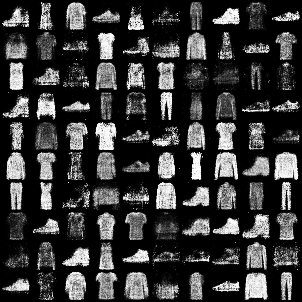

In [59]:
Image('./samples/fake_images-0110.png')

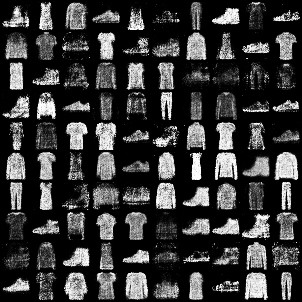

In [60]:
Image('./samples/fake_images-0120.png')

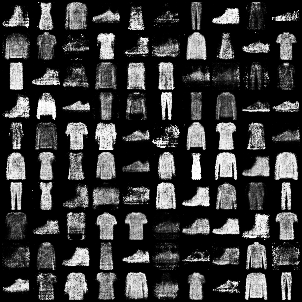

In [61]:
Image('./samples/fake_images-0130.png')

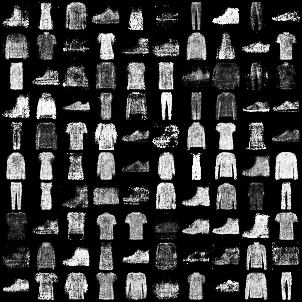

In [62]:
Image('./samples/fake_images-0140.png')

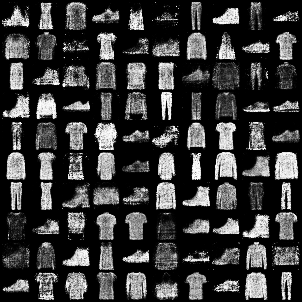

In [63]:
Image('./samples/fake_images-0150.png')

## Losses of Discriminator and Generator

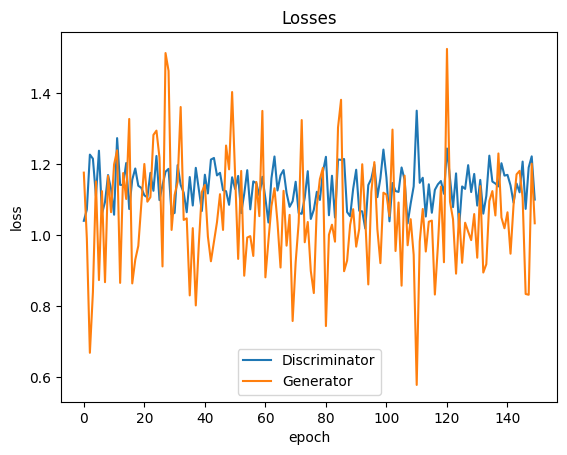

In [64]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

#### Real Score Vs Fake Score

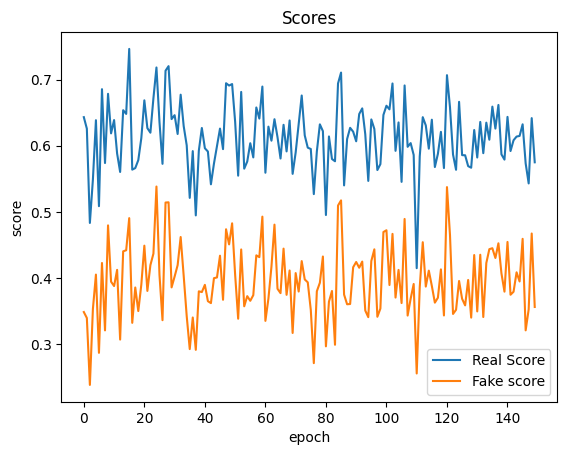

In [65]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

Github: https://github.com/shashankchintu99/semester3-projects/tree/main/deeplearning/assignments